<a href="https://colab.research.google.com/github/cgionc/SimuladorBotAtivoFinanceiro/blob/main/SimuladorSwingtradeCandle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Digite a quantidade inicial de Pontos Artificiais
20
Replicação com N= 200
Replicação com N= 223
Replicação com N= 233

 Observar

 Pontos Encontrados: P1= 5.18 P2= 5.017855062731733 P3= 5.403944947721369

Saldo Acumulado =  [0.]

 Observar

 Pontos Encontrados: P1= 5.017855062731733 P2= 5.403944947721369 P3= 5.039720982671035

Saldo Acumulado =  [0. 0.]

 Tentar Comprar em:  5.403944947721369

 Desistiu da Compra

 Pontos Encontrados: P1= 5.403944947721369 P2= 5.039720982671035 P3= 5.153952331492645

Saldo Acumulado =  [0. 0. 0.]

 Tentar Vender em:  5.039720982671035

 Desistiu da Venda

 Pontos Encontrados: P1= 5.039720982671035 P2= 5.153952331492645 P3= 5.090716697754476

Saldo Acumulado =  [0. 0. 0. 0.]

 Tentar Comprar em:  5.153952331492645

 Comprado em  5.153952331492645  Stop Loss:  5.090716697754476  Stop Gain:  6.746122369926798

 Pontos Encontrados: P1= 5.153952331492645 P2= 5.090716697754476 P3= 5.190622801615811

 Observar

 Pontos Encontrados: P1= 5.090716697754476 P2= 

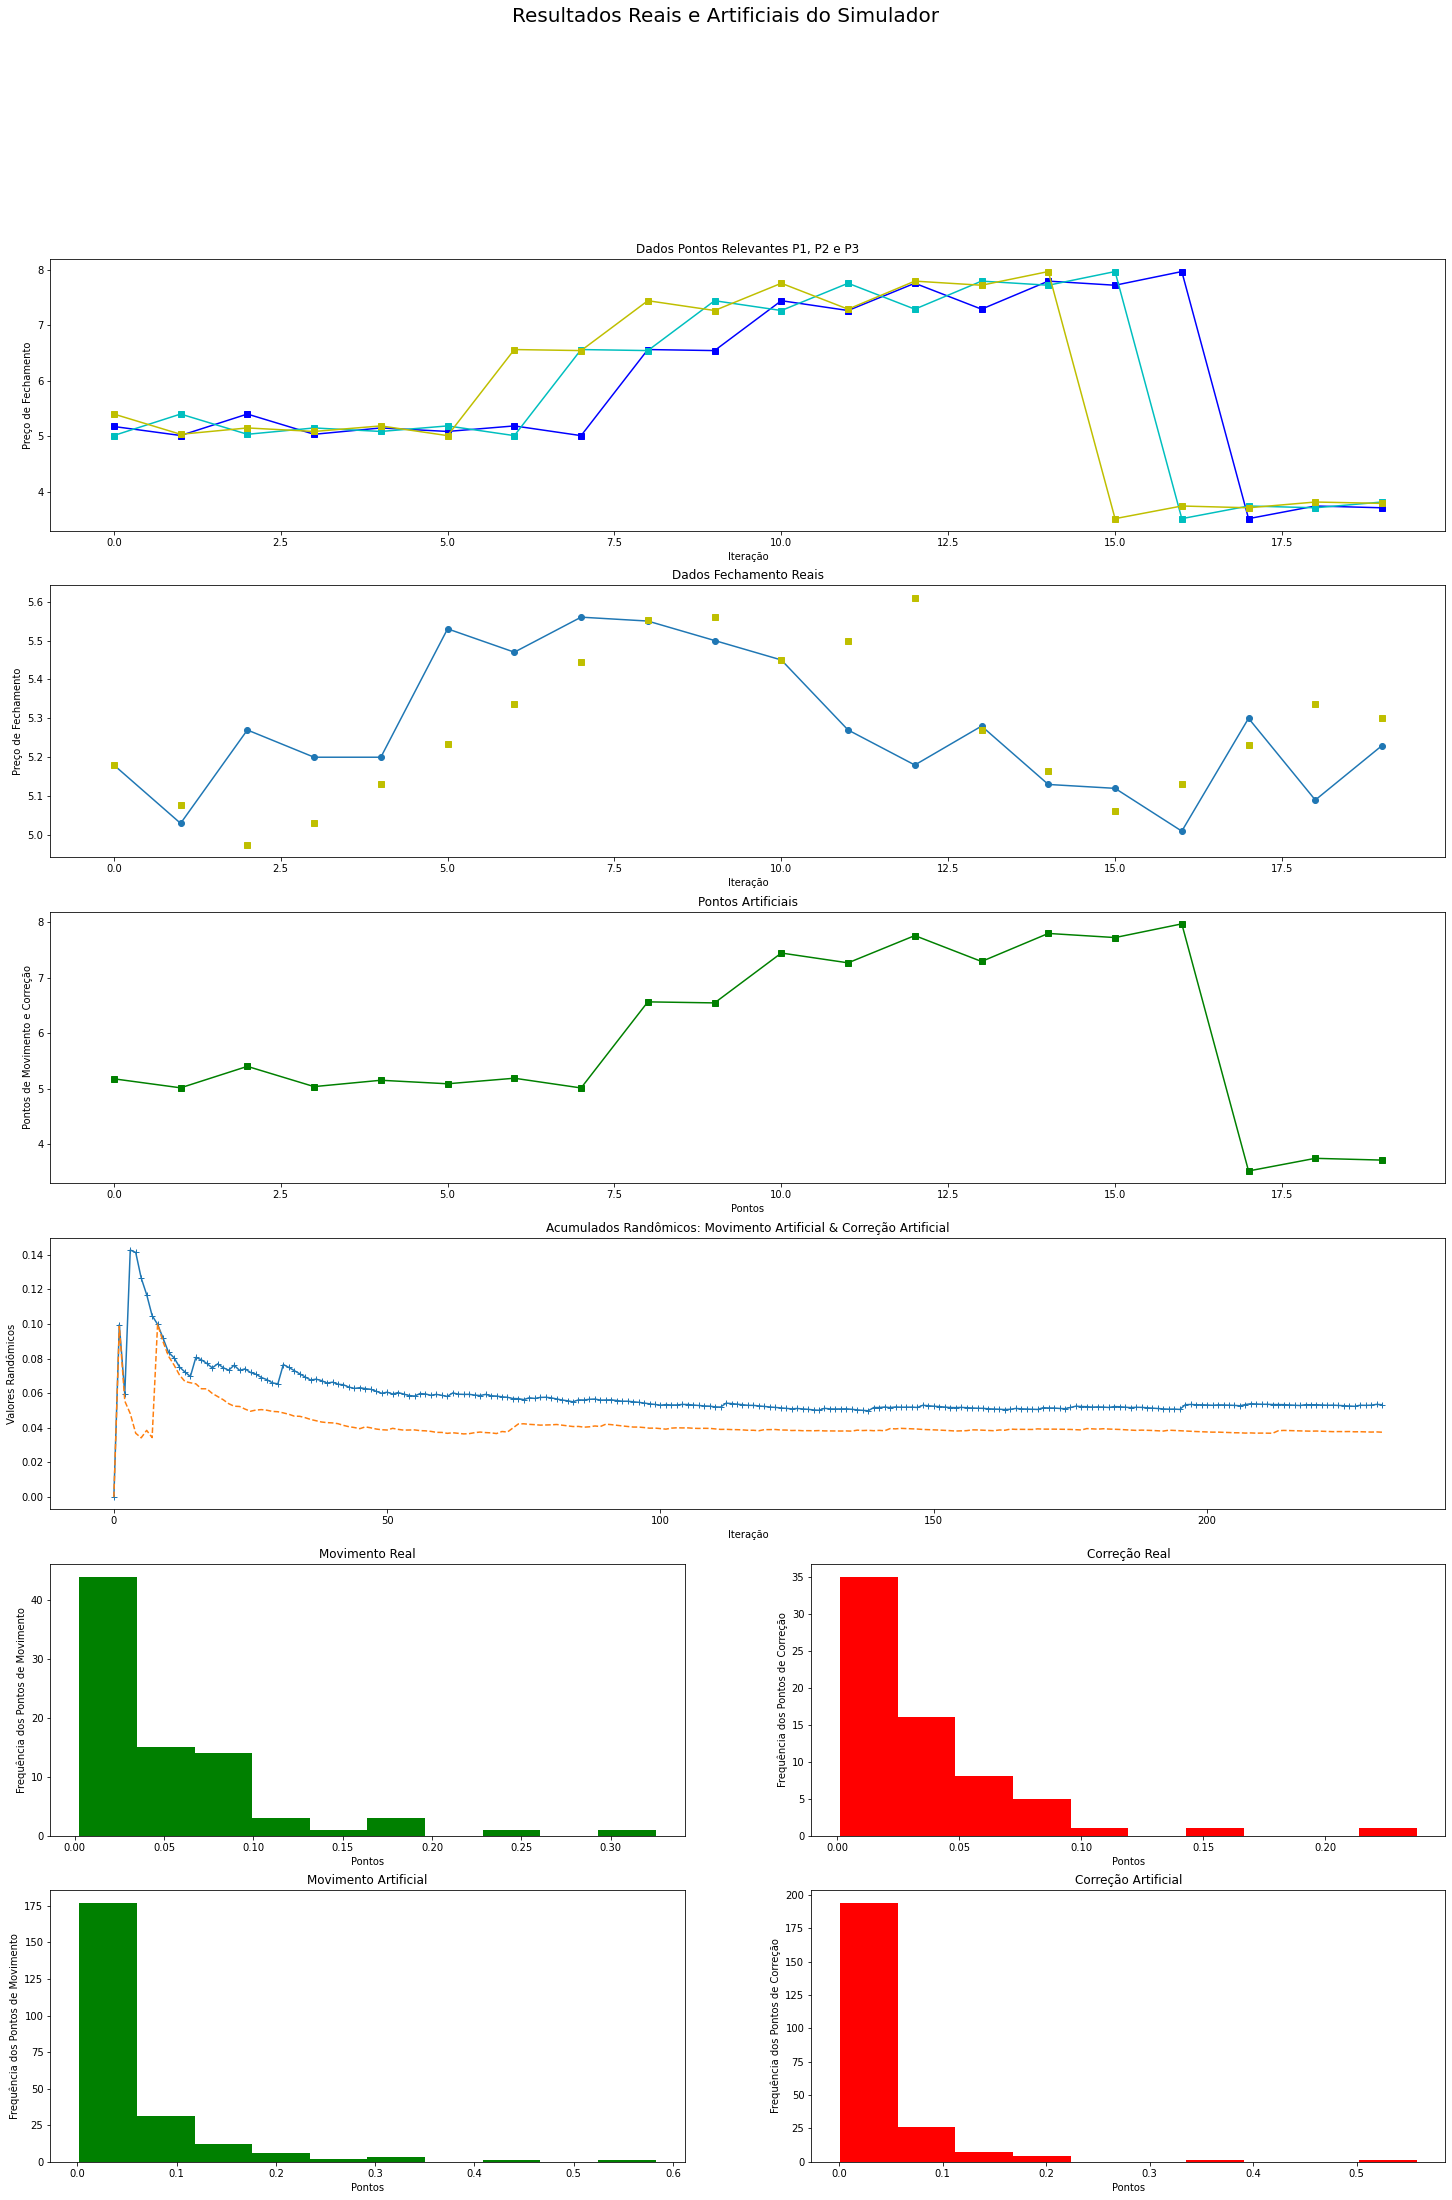

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import matplotlib.gridspec as gridspec

####################################################
# Funções para calcular Média e Desvio Padrão usando Logaritmo
#
# Função para calcular Média com Logaritmo
def cal_media(Distancia):
  soma = 0
  count = len(Distancia)
  for i in range(0, count):
    soma += math.log(Distancia[i])
  media_mov = soma/count
  return media_mov
# Função para calcula Desvio Padrão com Logaritmo    
def cal_desvio(Distancia, media_mov):
  soma = 0
  count = len(Distancia)
  for i in range(0, count):
    soma += (math.log(Distancia[i]) - media_mov)**2
  desvio_mov = (soma/count)**(0.5)
  return desvio_mov
# Função para Calcular a Precisão
def ObterPrecisaoH(TamanhoAmostra,DesvioPadrao,Alfa):
  TabelaStudentT = pd.read_csv("https://raw.githubusercontent.com/cgionc/SimuladorBotAtivoFinanceiro/main/TabelaStudentT.csv")
  TabelaStudentTAlfa = TabelaStudentT[Alfa]
  TabelaStudentTN = TabelaStudentT['Bicaudal']
  NStudent = TamanhoAmostra - 1
  t = 0
  for i in range(len(TabelaStudentTAlfa)):
    if NStudent == TabelaStudentTN[i]:
      t = TabelaStudentTAlfa[i]
    else:
      if NStudent >= 30 and NStudent < 40:
        t = TabelaStudentTAlfa[29]
      else:
        if NStudent >= 40 and NStudent < 50:
          t = TabelaStudentTAlfa[30]  
        else:
          if NStudent >= 50 and NStudent < 60:
            t = TabelaStudentTAlfa[31] 
          else:
            if NStudent >= 60 and NStudent < 80:
              t = TabelaStudentTAlfa[32]   
            else:
              if NStudent >= 80 and NStudent < 100:
                t = TabelaStudentTAlfa[33]
              else:
                if NStudent >= 100 and NStudent < 120:
                  t = TabelaStudentTAlfa[34]
                else:
                  if NStudent == 120:
                    t = TabelaStudentTAlfa[35]      
                  else:
                    if NStudent > 120:
                      t = TabelaStudentTAlfa[36]  
  ValorPrecisao = t * (DesvioPadrao / math.sqrt(TamanhoAmostra))
  return ValorPrecisao
# Função para Estimar o valor de N  
def EstimarNnovo(TamanhoAmostra,Hpretendido,Hestimado):
  Nestimado = round(TamanhoAmostra * pow((Hestimado / Hpretendido),2))
  return Nestimado
####################################################
# Inicializar variáveis
#
PontoA = 0.0
PontoB = 0.0
DistanciaAB = 0.0
#
Tendencia = 'Baixa'
AtingiuLimiar = 'Não'
#
Indice = np.array([])
SARParabolic = np.array([])
Fechamento = np.array([])
Movimento = np.array([])
Correcao = np.array([])
MovimentoArtificial = np.array([])
MovimentoArtificialRand = np.array([])
MovimentoArtificialRandAcumulado = np.array([])
MovimentoArtificialRandAcumuladoMedio = np.array([])
CorrecaoArtificial = np.array([])
CorrecaoArtificialRand = np.array([])
CorrecaoArtificialRandAcumulado = np.array([])
CorrecaoArtificialRandAcumuladoMedio = np.array([])
PontoArtificial = np.array([])
####################################################
# Importar dados reais do arquivo de trace do ativo
url = 'https://raw.githubusercontent.com/cgionc/SimuladorBotAtivoFinanceiro/main/MGLU3_Candle1D.csv'
Dados = pd.read_csv(url)
DadosFechamento = Dados['Fechamento']
DadosFechamentoOrdenados = list(reversed(DadosFechamento))
# Considerar todo o arquivo de trace
TamanhoReal = len(DadosFechamentoOrdenados)
# Somente os preços de fechamento de 0 até Tamanho Real
for i in range(TamanhoReal):
  Fechamento = np.append(Fechamento,i)
  Fechamento[i] = DadosFechamentoOrdenados[i]
####################################################
# Encontrar os Pontos A e B dos Movimentos e Correções
#
# Indicador SARParabolic sinalizando qual o sentido do Movimento ou Correcao
for i in range(len(Fechamento)):
  Indice = np.append(Indice,i)
  SARParabolic = np.append(SARParabolic,0)
  # Inicializar o SARParabolic no Primeiro preço de Fechamento
  if i == 0:
    SARParabolic[i] = Fechamento[i]
  else:
    if AtingiuLimiar == 'Sim':
      AtingiuLimiar = 'Não'
      SARParabolic[i] = Fechamento[i-2]
      if Tendencia == 'Alta':
        Tendencia = 'Baixa'
        # Encontrar maior ponto do vetor
        PontoA = SARParabolic[i]
        # Calcular Movimento  
        if PontoB > 0:
          DistanciaAB = (PontoA - PontoB) / PontoB           
          if DistanciaAB > 0:
            Movimento = np.append(Movimento,DistanciaAB)
          else:  
            if DistanciaAB < 0:
              Correcao = np.append(Correcao,abs(DistanciaAB))            
      else: #Tendencia == 'Baixa'
        Tendencia = 'Alta' 
        # Encontrar maior ponto do vetor
        PontoB = SARParabolic[i]
        # Calcular Movimento  
        if PontoA > 0:
          DistanciaAB = (PontoB - PontoA)  / PontoA
          if DistanciaAB > 0:
            Movimento = np.append(Movimento,DistanciaAB)
          else:
            if DistanciaAB < 0:  
              Correcao = np.append(Correcao,abs(DistanciaAB))
    else: #AtingiuLimiar == 'Não':  
      # Atualizar o valor de SARParabolic com fator de 0.02   
      fator = 0.02
      if Tendencia == 'Alta':
        SARParabolic[i] = SARParabolic[i-1] * (1+fator)
      else: #Tendencia == 'Baixa':
        SARParabolic[i] = SARParabolic[i-1] * (1-fator)
      # Verificar se o Fechamento atingiu o limiar para mudar o sentido da tendência       
      if Tendencia == 'Alta':
        if Fechamento[i] < SARParabolic[i]:
          AtingiuLimiar = 'Sim'
      else: #Tendencia == 'Baixa':
        if Fechamento[i] > SARParabolic[i]:
          AtingiuLimiar = 'Sim'    
####################################################
# Calcular Média e Desvio Padrão usando Logaritmo
#
if len(Movimento) > 1 and len(Correcao) > 1:
  # Mu calculado para Lognormal
  MovimentoMu = cal_media(Movimento)
  # Sigma calculado para Lognormal
  MovimentoSigma = cal_desvio(Movimento,MovimentoMu)
  # Mu calculado para Lognormal
  CorrecaoMu = cal_media(Correcao)
  # Sigma calculado para Lognormal
  CorrecaoSigma = cal_desvio(Correcao,CorrecaoMu)
else:
  MovimentoMu = 0
  MovimentoSigma = 0
  CorrecaoMu = 0
  CorrecaoSigma = 0
####################################################
# Se o N estimado não for atendido, será preciso gerar mais números randômicos
print('Digite a quantidade inicial de Pontos Artificiais')
AmostraPiloto = int(input())
if AmostraPiloto > 2:
  # Metade para Movimento e metade para Correção
  Amostra = round(AmostraPiloto / 2)
  #TamanhoArtificial = Amostra
else:
  #TamanhoArtificial = 2
  Amostra = 2
#
MovimentoArtificialHpretendido = 0.01
CorrecaoArtificialHpretendido = 0.01
#
TamanhoArtificial = Amostra
while (TamanhoArtificial != 0):
  ####################################################
  # Inicializar arrays de dados artificiais
  MovimentoArtificial = []
  MovimentoArtificialRand = []
  MovimentoArtificialRandAcumulado = []
  MovimentoArtificialRandAcumuladoMedio = []
  #
  CorrecaoArtificial = []
  CorrecaoArtificialRand = []
  CorrecaoArtificialRandAcumulado = []
  CorrecaoArtificialRandAcumuladoMedio = []
  #
  PontoArtificial = []
  ####################################################
  # Gerar dados artificiais
  #
  #TODO: Gerar Atraso Artificial
  #Amu = 0.0
  #Asigma = 0.0
  #
  # Gerar todos os valores artificiais dos arrays de Movimento e Correção com a mesma semente e de uma única vez
  MovimentoArtificialRand = np.random.lognormal(MovimentoMu, MovimentoSigma, TamanhoArtificial)
  CorrecaoArtificialRand = np.random.lognormal(CorrecaoMu, CorrecaoSigma, TamanhoArtificial)
  # Acumular a média de números randômicos para analisar posteriormente
  for i in range(TamanhoArtificial):
    MovimentoArtificialRandAcumulado = np.append(MovimentoArtificialRandAcumulado,MovimentoArtificialRand[0])  
    MovimentoArtificialRandAcumuladoMedio = np.append(MovimentoArtificialRandAcumuladoMedio,0)  
    CorrecaoArtificialRandAcumulado = np.append(CorrecaoArtificialRandAcumulado,CorrecaoArtificialRand[0])
    CorrecaoArtificialRandAcumuladoMedio = np.append(CorrecaoArtificialRandAcumuladoMedio,0)
    if i > 0:
      MovimentoArtificialRandAcumulado[i] = MovimentoArtificialRandAcumulado[i-1] + MovimentoArtificialRand[i]
      CorrecaoArtificialRandAcumulado[i] = CorrecaoArtificialRandAcumulado[i-1] + CorrecaoArtificialRand[i]
      MovimentoArtificialRandAcumuladoMedio[i] = MovimentoArtificialRandAcumulado[i] / i
      CorrecaoArtificialRandAcumuladoMedio[i] = CorrecaoArtificialRandAcumulado[i] / i 
  # TODO: Recortar o Regime Transitório (aproximadamente 10%, porém tem que encontrar algum valor correspondente
  # relacionado à variância)
  WarmUP = 0.001
  Transitorio = round(WarmUP * TamanhoArtificial)
  for i in range(TamanhoArtificial):
    if i >= Transitorio:
      MovimentoArtificial = np.append(MovimentoArtificial,MovimentoArtificialRand[i])
  #
  for i in range(TamanhoArtificial):
    if i >= Transitorio:
      CorrecaoArtificial = np.append(CorrecaoArtificial,CorrecaoArtificialRand[i])
  # Gerar Pontos Artificiais
  Permanente = TamanhoArtificial - Transitorio
  for i in range(Permanente):
    PontoArtificial = np.append(PontoArtificial,0)
    if i == 0:
      PontoArtificial[i] = Fechamento[0]
      Impar = True
      Par = False
      j = 0
      k = 0
    else:
      if Par == True:  
        PontoArtificial[i] = PontoArtificial[i-1] * (1 + MovimentoArtificial[j])
        j+=1
        Par = False
        Impar = True
      else:
        if Impar == True:
          PontoArtificial[i] = PontoArtificial[i-1] * (1 - CorrecaoArtificial[k])
          k+=1
          Impar = False
          Par = True
  # Recalcula o novo desvio padrão para saber se é hora de parar
  MovimentoArtificialMediaNovo = np.mean(MovimentoArtificial)
  MovimentoArtificialDesvioPadraoNovo = np.std(MovimentoArtificial)
  CorrecaoArtificialMediaNovo = np.mean(CorrecaoArtificial)
  CorrecaoArtificialDesvioPadraoNovo = np.std(CorrecaoArtificial)
  # Alfa = 95%
  MovimentoArtificialH = ObterPrecisaoH(TamanhoArtificial,MovimentoArtificialDesvioPadraoNovo,'95%')
  MovimentoArtificialN = EstimarNnovo(TamanhoArtificial,MovimentoArtificialHpretendido,MovimentoArtificialH)
  #  
  CorrecaoArtificialH = ObterPrecisaoH(TamanhoArtificial,CorrecaoArtificialDesvioPadraoNovo,'95%')
  CorrecaoArtificialN = EstimarNnovo(TamanhoArtificial,CorrecaoArtificialHpretendido,CorrecaoArtificialH)
  #
  if (MovimentoArtificialH > MovimentoArtificialHpretendido) or (CorrecaoArtificialH > CorrecaoArtificialHpretendido):
    if MovimentoArtificialH > CorrecaoArtificialH:
      #TamanhoArtificial = TamanhoArtificial + MovimentoArtificialN    
      TamanhoArtificial = MovimentoArtificialN    
    else:
      if MovimentoArtificialH < CorrecaoArtificialH:
        #TamanhoArtificial = TamanhoArtificial + CorrecaoArtificialN      
        TamanhoArtificial = CorrecaoArtificialN
  else:
    TamanhoArtificial = 0
  if TamanhoArtificial > 0:  
    print('Replicação com N=',TamanhoArtificial)    
# Fim do While  
#
# TODO: Implementar o cálculo das diferenças das médias e desvio padrão dos dados Reais com os Artificais
#
#
####################################################
#TODO: Criar rotina para entrar e sair na operação de compra ou venda
#
# Função para Encontrar os Pontos Relevantes na Teoria de Dow
#def EncontrarPontosRelevantes(P1,P2):

  #return P3Estimado
# Função para Iniciar Operação
#def Operar():
  #while:
    #if AcionouGatilho():
      #d
#
#Fibonacci = 0.5
Fibonacci = 0.382
#Fibonacci = 0.618
#
P1 = np.array([])
P2 = np.array([])
P3 = np.array([])
#
Gatilho = np.array([])
StopLoss = np.array([])
StopGain = np.array([])
#
Saldo = 0.0
SaldoAcumulado = np.array([])
#
for i in range(round(len(PontoArtificial)/3)):
  if i == 0:
    Operacao = ''
    #P1 = np.append(P1,Fechamento[0])
    P1 = np.append(P1,PontoArtificial[0])
    #P2 = np.append(P2,Fechamento[0])
    P2 = np.append(P2,PontoArtificial[1])
    #P3 = np.append(P3,Fechamento[0])
    P3 = np.append(P3,PontoArtificial[2])
    Posicao = P1[0]
    #Gatilho = np.append(Gatilho,Fechamento[0])
    #StopLoss = np.append(StopLoss,Fechamento[0])
    #StopGain = np.append(StopGain,Fechamento[0])
    #print('\n Pontos Encontrados: P1=',P1[i],'P2=',P2[i],'P3=',P3[i])  
  else:
    #P1 = np.append(P1,PontoArtificial[2*i])
    #P2 = np.append(P2,PontoArtificial[2*i+1])
    #P3 = np.append(P3,PontoArtificial[2*i+2])
    P1 = np.append(P1,PontoArtificial[i+0])
    P2 = np.append(P2,PontoArtificial[i+1])
    P3 = np.append(P3,PontoArtificial[i+2])
    #print('\n Pontos Encontrados: P1=',P1[i],'P2=',P2[i],'P3=',P3[i])  
    #Gatilho = np.append(Gatilho,0.0)
    #StopLoss = np.append(StopLoss,0.0)
    #StopGain = np.append(StopGain,0.0)
  # Entrar na Compra se Tendência de Alta
  if P2[i-1] > P1[i-1] and P3[i-1] < P2[i-1] and P3[i-1] > P1[i-1] and Operacao != 'Comprado':
    #Posicao = P2[i-1] * (1 - MovimentoArtificial[i-1] * Fibonacci)
    PosicaoAnterior = Posicao
    Posicao = P2[i-1]
    #Posicao = P2[i]
    print('\n Tentar Comprar em: ',Posicao)      
    Gatilho = np.append(Gatilho,Posicao)
    # Sair da Operação por Reverter Tendência
    if Operacao == 'Vendido':
        Sair = PosicaoAnterior - Posicao
        print('\n Comprar para Sair da Reversão de Tendência ',Operacao,' com ',Sair)
        SL = 0.0
        SG = 0.0
        Posicao = 0.0
        Saldo = Saldo + Sair
        print('\n Saldo Parcial = ',Saldo)
        Operacao = 'Observando'    
    else:
      if P3[i] > Posicao:
        Operacao = 'Comprado'
        #SL = P1[i]
        SL = P2[i]
        #SG = Posicao * (1 + MovimentoArtificial[i-1])
        SG = P1[i] * (1 + MovimentoArtificial[i-1])
        StopLoss = np.append(StopLoss,SL)
        StopGain = np.append(StopGain,SG)        
        print('\n Comprado em ',Posicao,' Stop Loss: ',SL,' Stop Gain: ',SG)      
      else:  
          print('\n Desistiu da Compra')  
  # Entrar na Venda se Tendência de Baixa
  else:
    if P2[i-1] < P1[i-1] and P3[i-1] > P2[i-1] and P3[i-1] < P1[i-1] and Operacao != 'Vendido':
      #Posicao = P2[i] * (1 + CorrecaoArtificial[i-1] * Fibonacci)
      PosicaoAnterior = Posicao
      Posicao = P2[i-1]
      #Posicao = P2[i]
      print('\n Tentar Vender em: ',Posicao)  
      Gatilho = np.append(Gatilho,Posicao)
      # Sair da Operação por Reverter Tendência
      if Operacao == 'Comprado':
        Sair = Posicao - PosicaoAnterior
        print('\n Vender para Sair da Reversão de Tendência ',Operacao,' com ',Sair)
        SL = 0.0
        SG = 0.0
        Posicao = 0.0
        Saldo = Saldo + Sair
        print('\n Saldo Parcial = ',Saldo)
        Operacao = 'Observando'    
      else:  
        if P3[i] < Posicao:
          Operacao = 'Vendido'        
          #SL = P1[i]
          SL = P2[i]
          #SG = Posicao * (1 - CorrecaoArtificial[i-1])
          SG = P1[i] * (1 - CorrecaoArtificial[i-1])
          StopLoss = np.append(StopLoss,SL)
          StopGain = np.append(StopGain,SG)        
          print('\n Vendido em ',Posicao,' Stop Loss: ',SL,' Stop Gain: ',SG)  
        else:  
          print('\n Desistiu da Venda')
    else:
      print('\n Observar')  
  #
  print('\n Pontos Encontrados: P1=',P1[i],'P2=',P2[i],'P3=',P3[i])  
  #   
  # Verificar se houve Perda ou Ganho por SL ou SG
  if Operacao == 'Comprado':
    if P1[i] < SL or P2[i] < SL or P3[i] < SL:
      Perda = SL - Posicao
      print('\n Perda',Operacao,' de ',Perda)      
      SL = 0.0
      SG = 0.0
      Posicao = 0.0
      Saldo = Saldo + Perda
      print('\n Saldo Parcial = ',Saldo)
      Operacao = 'Observando'    
    else:
      if P1[i] >= SG or P2[i] >= SG or P3[i] >= SG:
        Ganho = SG - Posicao
        print('\n Ganho',Operacao,' de ',Ganho)
        SL = 0.0
        SG = 0.0
        Posicao = 0.0
        Saldo = Saldo + Ganho
        print('\n Saldo Parcial = ',Saldo)
        Operacao = 'Observando'    
  #        
  else:
    if Operacao == 'Vendido':
      if P1[i] > SL or P2[i] > SL or P3[i] > SL:
        Perda = Posicao - SL
        print('\n Perda',Operacao,' de ',Perda)
        SL = 0.0
        SG = 0.0
        Posicao = 0.0
        Saldo = Saldo + Perda
        print('\n Saldo Parcial = ',Saldo)
        Operacao = 'Observando'        
      else:
        if P1[i] <= SG or P2[i] <= SG or P3[i] <= SG:
          Ganho = Posicao - SG
          print('\n Ganho',Operacao,' de ',Ganho)
          Posicao = 0.0
          SL = 0.0
          SG = 0.0
          Saldo = Saldo + Ganho
          print('\n Saldo Parcial = ',Saldo)
          Operacao = 'Observando'        
    #          
    else:
      SaldoAcumulado = np.append(SaldoAcumulado,Saldo)
      print('\nSaldo Acumulado = ',SaldoAcumulado)
#
####################################################
#TODO: Verificar porque os dados randômicos não estão gerando valores acompanhando as máximas do ativo
####################################################
# Imprimir dados de fechamento reais com SARParabolic e pontos artificiais
fig = plt.figure(figsize=(25, 35)) 
fig.suptitle('Resultados Reais e Artificiais do Simulador',fontsize=20)
spec = fig.add_gridspec(ncols=2, nrows=6)
#
axs0 = fig.add_subplot(spec[0, :])
axs1 = fig.add_subplot(spec[1, :])
axs2 = fig.add_subplot(spec[2, :])
axs3 = fig.add_subplot(spec[3, :])
#
#axs0.plot(P1[0:AmostraPiloto],'sy',P2[0:AmostraPiloto],'sy',P3[0:AmostraPiloto],'sy',Gatilho[0:AmostraPiloto],'sg',StopLoss[0:AmostraPiloto],'sr',StopGain[0:AmostraPiloto],'sb')
axs0.plot(P1[0:AmostraPiloto],'s-b',P2[0:AmostraPiloto],'s-c',P3[0:AmostraPiloto],'s-y')
#axs0.plot(SARParabolic[0:AmostraPiloto],'sy',P1[0:AmostraPiloto],'sg',P2[0:AmostraPiloto],'sr',P3[0:AmostraPiloto],'sb')
axs0.set_title('Dados Pontos Relevantes P1, P2 e P3')
axs0.set_xlabel('Iteração')
axs0.set_ylabel('Preço de Fechamento')
#
axs1.plot(Fechamento[0:AmostraPiloto],'-o',SARParabolic[0:AmostraPiloto],'sy')
#axs1.plot(Fechamento[0:AmostraPiloto],'-o',SARParabolic[0:AmostraPiloto],'sy',Gatilho[0:AmostraPiloto],'sg',StopLoss[0:AmostraPiloto],'sr',StopGain[0:AmostraPiloto],'sb')
#axs1.plot(Fechamento[0:AmostraPiloto],'-o',SARParabolic[0:AmostraPiloto],'sy',P1[0:AmostraPiloto],'sg',P2[0:AmostraPiloto],'sr',P3[0:AmostraPiloto],'sb')
axs1.set_title('Dados Fechamento Reais')
axs1.set_xlabel('Iteração')
axs1.set_ylabel('Preço de Fechamento')
#
axs2.plot(PontoArtificial[0:AmostraPiloto],'-sg')
axs2.set_title('Pontos Artificiais')
axs2.set_xlabel('Pontos')
axs2.set_ylabel('Pontos de Movimento e Correção')
#
#axs3.plot(MovimentoArtificialRandAcumulado[WarmUP:],'-+',CorrecaoArtificialRandAcumulado[WarmUP:],'--')
axs3.plot(MovimentoArtificialRandAcumuladoMedio,'-+',CorrecaoArtificialRandAcumuladoMedio,'--')
axs3.set_title('Acumulados Randômicos: Movimento Artificial & Correção Artificial')
axs3.set_xlabel('Iteração')
axs3.set_ylabel('Valores Randômicos')
# Imprimir histogramas
axs4 = fig.add_subplot(spec[4,0])
axs5 = fig.add_subplot(spec[4,1])
axs6 = fig.add_subplot(spec[5,0])
axs7 = fig.add_subplot(spec[5,1])
#
axs4.hist(Movimento,10,color='green')
axs4.set_title('Movimento Real')
axs4.set_xlabel('Pontos')
axs4.set_ylabel('Frequência dos Pontos de Movimento')
#
axs5.hist(Correcao,10,color='red')
axs5.set_title('Correção Real')
axs5.set_xlabel('Pontos')
axs5.set_ylabel('Frequência dos Pontos de Correção')
#
axs6.hist(MovimentoArtificial,10,color='green')
axs6.set_title('Movimento Artificial')
axs6.set_xlabel('Pontos')
axs6.set_ylabel('Frequência dos Pontos de Movimento')
#
axs7.hist(CorrecaoArtificial,10,color='red')
axs7.set_title('Correção Artificial')
axs7.set_xlabel('Pontos')
axs7.set_ylabel('Frequência dos Pontos de Correção')
#
plt.show()
